In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,recall_score, precision_recall_curve,f1_score,precision_score
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from collections import Counter

In [3]:
# load data and labels
data = pd.read_csv(r'Data/train/train.csv')
target = pd.read_csv(r'Data/train/target_train.csv')

# concat them on unique id
merged = pd.merge(data, target, on='PROX_TRAZ', how='outer')

In [5]:
# view an example of the data
data.head()

,PROX_TRAZ,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60
1,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61
2,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61
3,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61
4,I-B-XA1207672-190528-02374,158.7,165.79,178.4,112.09,11.88,12.15,NaN,11.97,6.62,25.99,22.3,97.13,6.63


In [6]:
target.head()

,PROX_TRAZ,Binar OP130_Resultat_Global_v
0,I-B-XA1207672-190429-00688,0
1,I-B-XA1207672-190712-03462,0
2,I-B-XA1207672-190803-00051,0
3,I-B-XA1207672-190508-03248,0
4,I-B-XA1207672-190528-02374,0


Gain insights by analyzing the date which defects occured. Further questions that can be ask by factory owners pinpoint the cause and minimize defects in the future:

1. What was the factory condition like on that date?
2. What causes the number of defects to be that high on that particular month/date?
3. Was an inexprienced employee handle production? etc.

Text(0, 0.5, 'No. of Defects')

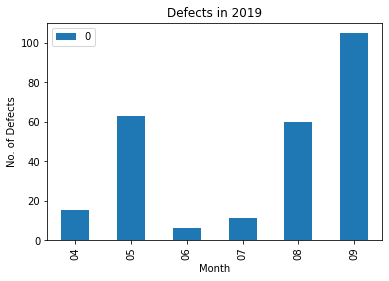

In [4]:
defects = merged.loc[merged['Binar OP130_Resultat_Global_v'] == 1]

def getDate(date):
    date = date.split("-")[3]
    return date

def getMonth(date):
    month = date[2:4]
    return month

getDate('I-B-XA1207672-190429-00688')
month_list = []
date_list = []
for i in defects['PROX_TRAZ']:
    date = getDate(i)
    month = getMonth(date)
    date_list.append(date)
    month_list.append(month)
month_list.sort()

count = Counter(month_list)
df = pd.DataFrame.from_dict(count, orient='index')
ax = df.plot(kind='bar')
ax.set_title("Defects in 2019")
ax.set_xlabel("Month")
ax.set_ylabel("No. of Defects")

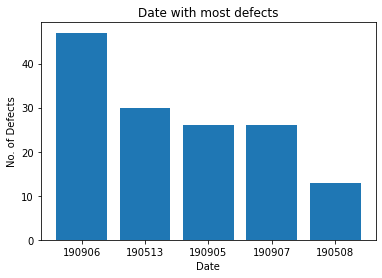

In [5]:
counter = Counter(date_list)

top_values = counter.most_common(5)
values, frequencies = zip(*top_values)

# Plot the values and frequencies
plt.bar(values, frequencies)
plt.xlabel('Date')
plt.ylabel('No. of Defects')
plt.title('Date with most defects')
plt.show()

## Data Understanding & Preprocessing

In [7]:
merged.describe()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar OP130_Resultat_Global_v
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,13839.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,159.929030,156.848521,159.608017,113.343240,11.970267,12.256785,0.388248,11.971025,6.547987,23.628592,17.859080,97.720900,6.550489,0.008667
std,15.673914,11.306632,15.108209,3.510567,0.175546,0.065315,0.024345,0.003048,0.097825,2.544595,6.770752,6.839611,0.095064,0.092692
min,101.900000,0.000000,82.000000,99.990000,0.000000,12.030000,0.240000,11.970000,5.670000,0.000000,6.300000,0.000000,5.740000,0.000000
25%,148.700000,149.140000,149.400000,111.040000,11.850000,12.210000,0.380000,11.970000,6.410000,22.270000,13.500000,94.320000,6.420000,0.000000
50%,158.000000,156.100000,158.700000,113.160000,12.040000,12.260000,0.390000,11.970000,6.610000,23.870000,16.300000,98.525000,6.610000,0.000000
75%,169.300000,164.310000,168.900000,115.370000,12.080000,12.300000,0.410000,11.970000,6.620000,25.290000,20.100000,102.260000,6.610000,0.000000
max,198.300000,196.920000,198.100000,165.140000,12.190000,12.500000,0.420000,11.990000,6.670000,43.410000,84.600000,127.300000,6.670000,1.000000


Most of the features does not have a direct correlation with target variable. 

Correlation between features



<AxesSubplot:>

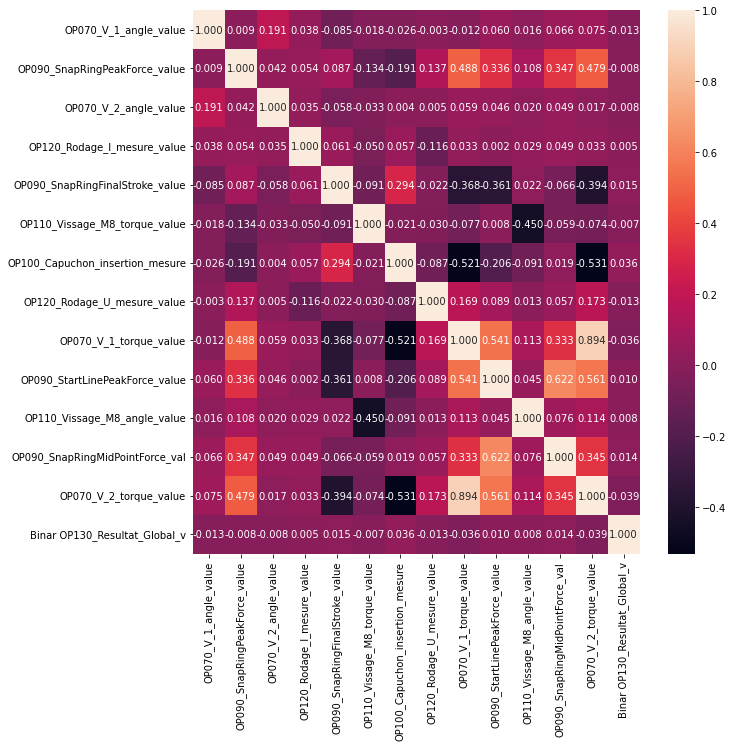

In [6]:
print("Correlation between features\n")
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(merged.corr(),annot=True,fmt='.3f')

OP070_V_1_torque_value and OP070_V_2_torque_value are highly correlated (>0.8), meaning that they are almost the similar and the model would not learn much additional info, so keeping one of them will do.  

In [4]:
# drop the OP070_V_1_torque_value column

merged = merged.drop(['OP070_V_1_torque_value'], axis=1)

In [5]:
# Get the class distribution

neg, pos = np.bincount(merged['Binar OP130_Resultat_Global_v'])
total = neg + pos

distribution = merged['Binar OP130_Resultat_Global_v'].value_counts()
print("Distribution of classes:\n")
print(distribution)
print("\n")
print('Positive: {} ({:.2f}% of dataset)\nNegative:{} ({:.2f}% of dataset) '.format(
    pos, 100 * pos / total, neg,100*neg/total))

Distribution of classes:

0    29740
1      260
Name: Binar OP130_Resultat_Global_v, dtype: int64


Positive: 260 (0.87% of dataset)
Negative:29740 (99.13% of dataset) 


In [6]:
print("Number of missing values based on columns\n")
print(merged.isna().sum())

Number of missing values based on columns

PROX_TRAZ                              0
OP070_V_1_angle_value                  0
OP090_SnapRingPeakForce_value          0
OP070_V_2_angle_value                  0
OP120_Rodage_I_mesure_value            0
OP090_SnapRingFinalStroke_value        0
OP110_Vissage_M8_torque_value          0
OP100_Capuchon_insertion_mesure    16161
OP120_Rodage_U_mesure_value            0
OP090_StartLinePeakForce_value         0
OP110_Vissage_M8_angle_value           0
OP090_SnapRingMidPointForce_val        0
OP070_V_2_torque_value                 0
Binar OP130_Resultat_Global_v          0
dtype: int64


In [7]:
a = merged[merged['OP100_Capuchon_insertion_mesure'].isna()]
print("Number of missing values for each class")
print(np.bincount(a['Binar OP130_Resultat_Global_v']))

#merged = merged.dropna()

Number of missing values for each class
[16067    94]


If the rows with NaN values are drop, it would decrease the already limited samples of positive class. 94 out of 260 samples of positive class would be dropped, causing a severe information loss. 

In [8]:
# define input and target variable

y_col = 'Binar OP130_Resultat_Global_v'
X = merged[merged.columns.drop([y_col,'PROX_TRAZ'])]
y = merged[y_col]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<b> Imbalanced Class </b>

The class distribution of this dataset is heavily imbalanced, I experimented with two method to address this problem:

1. Over & Under Sampling
- Over and undersampling is used to increase the samples of positive class and reduce the number of negative class.
- SMOTE is used to create synthetic data of the positive class, while the negative class is randomly reduced. Only the training data is sampled, the testing data is not effected as it should be as close as real life data as possible. 
- After testing this with imputation, the model keeps overfitting and is not able to produce a good result, so sampling is ommitted from the final experiment. 

2. Class Weights
- Another way is to tell the model to focus more on the minority class during training, class weights is used to achieve this. 
- Weights are calculated based on the number of samples between majority and minority class. For example, if class A is two times more than Class B, the weights of class B will be multipled by 2 during training, when the model makes a wrong prediction on class B, it would receive more penalty. 

In real life, the porportion of data will probably be imbalanced as well. If test data is also sampled, during evaluation, the score will not truely reflect real life production performance. 

In [10]:
# Over & Undersampling

#imputer = KNNImputer(n_neighbors=7, metric='nan_euclidean')

#oversample = SMOTE(sampling_strategy=0.2,random_state=42)
#under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)

#X_train1 = imputer.fit_transform(X_train)
#X_train1, y_train1 = oversample.fit_resample(X_train1, y_train)
#X_train1, y_train1 = under.fit_resample(X_train1, y_train1)

#new_neg, new_pos = np.bincount(y_train1)
#print("No. of negatives after sampling: %d"%(new_neg))
#print("No. of positives after sampling: %d"%(new_pos))

## XGBoost

One of the main reason XGBoost is chosen is that it can handle missing values automatically and perform inference on data with missing values. Assuming that during production, insertion measure may be missing from the data as well, 

If using other methods like SVM, the missing values will have to be fill in either manually or using algorithms like imputation before testing and inference, XGBoost lets us test with data as close to real life as possible.

<b> Imputation </b>\
For experiment purposes, XGBoost will be trained with data with and without imputation. 

<b> Random search with cross fold validation </b> \
Random search is used to find the optimal hyperparameters, it comes with cross fold validation to to reduce overfitting. In this experiment, the data is split into 3 folds.

<b> Performance Monitoring </b> \
The vanilla f1 score is used to decide the best hyperparameter instead of the macro-averaged f1 is because I want it to return a model that is able to predict the defect class more. 

In [21]:
# class weights for imbalanced data
scale_pos_weight = neg/pos

imputer = KNNImputer(metric='nan_euclidean')
xgb = XGBClassifier(scale_pos_weight =scale_pos_weight,objective='binary:logistic')

#pipe_xg = Pipeline(steps=[("impute", imputer),("xgb", xgb)])
pipe_xg = Pipeline(steps=[("xgb", xgb)])

params_xgb={
 "xgb__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "xgb__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
 "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


random_xgb = RandomizedSearchCV(estimator=pipe_xg, param_distributions=params_xgb,cv=3, n_jobs=1,
                    verbose=4, scoring='f1')

xgb_result = random_xgb.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=7;, score=0.000 total time=   0.3s
[CV 2/3] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=7;, score=0.000 total time=   0.3s
[CV 3/3] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=15, xgb__min_child_weight=7;, score=0.000 total time=   0.3s
[CV 1/3] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=7;, score=0.039 total time=   0.0s
[CV 2/3] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=7;, score=0.037 total time=   0.0s
[CV 3/3] END xgb__colsample_bytree=0.5, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=7;, score=0.036 total time=   0.0s
[CV

In [22]:
print(xgb_result.best_params_)
print(xgb_result.best_score_)

{'xgb__min_child_weight': 7, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 0.5}
0.03700646832107396


In [23]:
# train model on best hyperparameters
xgb_tuned = XGBClassifier(scale_pos_weight=scale_pos_weight,objective='binary:logistic',
                          min_child_weight=7,max_depth=3,learning_rate=0.05,gamma=0.4,
                          colsample_bytree=0.5)

xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Precision: 0.016242937853107344
Recall: 0.46938775510204084
F1-score: 0.031399317406143344
Macro avg. F1-score: 0.4483527199275615
Class distribution in testing set [5951   49]


True Postive Rate: 0.469388
True Negative Rate: 0.765922
False Postive Rate: 0.234078
False Negative Rate: 0.530612


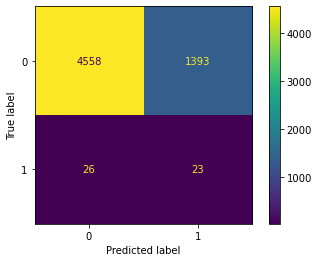

In [24]:
#X_test1 = imputer.fit_transform(X_test) 
y_pred = xgb_tuned.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred,average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Macro avg. F1-score:", f1_macro)

# display the confusion matrix
cm= confusion_matrix(y_test, y_pred, labels=xgb_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_tuned.classes_)
disp.plot()
print("Class distribution in testing set",np.bincount(y_test))
print("\n")

tn, fp, fn, tp =cm.ravel()
print("True Postive Rate: %f"%(tp/(tp+fn)))
print("True Negative Rate: %f"%(tn/(tn+fp)))
print("False Postive Rate: %f"%(fp/(tn+fp)))
print("False Negative Rate: %f"%(fn/(tp+fn)))

In [25]:
from sklearn.metrics import classification_report

target_names = ['Negative(OK)', 'Positive(KO)']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Negative(OK)       0.99      0.77      0.87      5951
Positive(KO)       0.02      0.47      0.03        49

    accuracy                           0.76      6000
   macro avg       0.51      0.62      0.45      6000
weighted avg       0.99      0.76      0.86      6000



Another insight that can be gained by analyzing the feature importance of the model in classfiying the defect. What are the main indicator that a product is going to have a defect? 

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


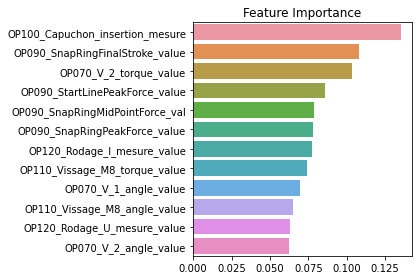

In [45]:
importances = xgb_tuned.feature_importances_

# Sort the feature importance in descending order

sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = data.columns[1:]

plt.title('Feature Importance')
sns.barplot( importances[sorted_indices],X.columns[sorted_indices])
plt.tight_layout()
plt.show()

In [36]:
defects.columns

Index(['PROX_TRAZ', 'OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value',
       'Binar OP130_Resultat_Global_v'],
      dtype='object')

In [40]:
defects = merged.loc[merged['Binar OP130_Resultat_Global_v'] == 1]
non_defects = merged.loc[merged['Binar OP130_Resultat_Global_v'] == 0]
defects['OP090_SnapRingFinalStroke_value'].describe()

count    260.000000
mean      11.999000
std        0.106817
min       11.720000
25%       11.900000
50%       12.050000
75%       12.080000
max       12.130000
Name: OP090_SnapRingFinalStroke_value, dtype: float64

In [41]:
non_defects['OP090_SnapRingFinalStroke_value'].describe()

count    29740.000000
mean        11.970015
std          0.176009
min          0.000000
25%         11.850000
50%         12.040000
75%         12.080000
max         12.190000
Name: OP090_SnapRingFinalStroke_value, dtype: float64

## Conclusion

For this problem, it is more important to be able to detect the positive class(defect) correctly compared to the negative class(non-defect) as it would lead to a lot of problems if the the defected item is missclassified and shipped out to customers. 

<b>Macro-average f1 score</b> and <b>recall</b> should be the main evaluation metric when tuning the model, as the purpose is to able to detect as much defects as possible. Recall shows how well the model is able to correctly detect defects while macro-average f1 score is able to show how the model performs overall on both positive and negative class.  While correctly detecting defect, we should also try to reduce excessive false positives. 

As seen from the classification report above, using the standard F1 score does not accurately reflect the model's performance as the test data is too heavily imbalanced. Although the model is able to classify a majority of the negative class correctly, it is still returning a low score. 

